# Refinement

We try another model with more wrangling of the data

In [83]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing
import statsmodels.formula.api as sm
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore") # ignore warning from libraries 
import math 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


In [2]:
# define column header names in a list
names=["id", "date", "bedrooms", "bathrooms","sqft_living", "sqft_lot", "floors", "waterfront", "view", "condition", "grade", "sqft_above", "sqft_basement", "yr_built", "yr_renovated", "zipcode", "lat", "long", "sqft_living15", "sqft_lot15", "price"]

In [3]:
# Import data into pandas dataframe. I am using the original data again
df = pd.read_csv('regression_data.csv',names=names )

In [4]:
# check if the import worked 
df.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,10/13/14,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,12/9/14,3,2.25,2570,7242,2.0,0,0,3,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,2/25/15,2,1.00,770,10000,1.0,0,0,3,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
3,2487200875,12/9/14,4,3.00,1960,5000,1.0,0,0,5,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
4,1954400510,2/18/15,3,2.00,1680,8080,1.0,0,0,3,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000


In [5]:
# remove the duplicate id's again and only keep the most recent one

# first we need to convert the date column to datetime
df['date'] = pd.to_datetime(df['date'])

# sort the dataframe by id and date
df = df.sort_values(by=['id', 'date'])

#drop all duplicate ID's, keep the last one
df_drop = df.drop_duplicates(['id'], keep='last')

#check if that worked and we have less rows
df_drop.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 2495 to 15937
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21420 non-null  int64         
 1   date           21420 non-null  datetime64[ns]
 2   bedrooms       21420 non-null  int64         
 3   bathrooms      21420 non-null  float64       
 4   sqft_living    21420 non-null  int64         
 5   sqft_lot       21420 non-null  int64         
 6   floors         21420 non-null  float64       
 7   waterfront     21420 non-null  int64         
 8   view           21420 non-null  int64         
 9   condition      21420 non-null  int64         
 10  grade          21420 non-null  int64         
 11  sqft_above     21420 non-null  int64         
 12  sqft_basement  21420 non-null  int64         
 13  yr_built       21420 non-null  int64         
 14  yr_renovated   21420 non-null  int64         
 15  zipcode        2

In [6]:
# we will directly drop the columns "ID", "lat", "long" 
# since they provide no value to our analysis according to the correlation matrix

df_drop=df_drop.drop(['id', 'lat','long'], axis = 1) 

In [7]:
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 2495 to 15937
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           21420 non-null  datetime64[ns]
 1   bedrooms       21420 non-null  int64         
 2   bathrooms      21420 non-null  float64       
 3   sqft_living    21420 non-null  int64         
 4   sqft_lot       21420 non-null  int64         
 5   floors         21420 non-null  float64       
 6   waterfront     21420 non-null  int64         
 7   view           21420 non-null  int64         
 8   condition      21420 non-null  int64         
 9   grade          21420 non-null  int64         
 10  sqft_above     21420 non-null  int64         
 11  sqft_basement  21420 non-null  int64         
 12  yr_built       21420 non-null  int64         
 13  yr_renovated   21420 non-null  int64         
 14  zipcode        21420 non-null  int64         
 15  sqft_living15  2

In [8]:
# define a quick function to convert the year renovated into a boolean value
# this is because we know from our real estate experience, that a renovation has an impact on the price, 
# but the year of renovation usually doesn't matter, only the fact that it got renovated

def boolean(x):
    if x == 0:
        n = 0
    elif x > 0:
        n = 1
    return n

In [9]:
# apply booloean function to yr_renovated colum. This means, I'll only tell the model wether or not a renovation happened. 
# This also helps with the distribution of the data
df_drop['yr_renovated']=df_drop['yr_renovated'].apply(boolean)

# do the same for sqft_basement, only acting as indicator on wether or not there is a basement
df_drop['sqft_basement']=df_drop['sqft_basement'].apply(boolean)

# do the same for view, only acting as indicator on wether or not there is a view
df_drop['view']=df_drop['view'].apply(boolean)


# check if that worked by looking at the head again
df_drop.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,price
2495,2015-04-22,6,3.00,2400,9373,2.0,0,0,3,7,2400,0,1991,0,98002,2060,7316,300000
6729,2014-05-08,4,1.75,2060,26036,1.0,0,0,4,8,1160,1,1947,0,98166,2590,21891,647500
8404,2014-08-11,3,1.00,1460,43000,1.0,0,0,3,7,1460,0,1952,0,98166,2250,20023,400000
8800,2015-04-01,3,1.00,1430,7599,1.5,0,0,4,6,1010,1,1930,0,98168,1290,10320,235000
3553,2015-03-19,4,2.00,1650,3504,1.0,0,0,3,7,760,1,1951,1,98144,1480,3504,402500


In [10]:
# now we look at the unique values for each row
for c in df_drop.columns.tolist():       #iterate over a list of the columns  
    print(c, len(df_drop[c].unique()))   #print the colum header and the unique values
# the duplicates are succesfully removed from the dataframe

date 372
bedrooms 12
bathrooms 29
sqft_living 1034
sqft_lot 9776
floors 6
waterfront 2
view 2
condition 5
grade 11
sqft_above 942
sqft_basement 2
yr_built 116
yr_renovated 2
zipcode 70
sqft_living15 777
sqft_lot15 8682
price 3595


In [11]:
# We will transform the date column to ordinal format 
# to make it applicable for the model and keeop the cyclical characteristics of the data
df_drop['date']=df_drop['date'].apply(lambda x: x.toordinal())


In [12]:
# check dataframe
df_drop.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,price
2495,735710,6,3.00,2400,9373,2.0,0,0,3,7,2400,0,1991,0,98002,2060,7316,300000
6729,735361,4,1.75,2060,26036,1.0,0,0,4,8,1160,1,1947,0,98166,2590,21891,647500
8404,735456,3,1.00,1460,43000,1.0,0,0,3,7,1460,0,1952,0,98166,2250,20023,400000
8800,735689,3,1.00,1430,7599,1.5,0,0,4,6,1010,1,1930,0,98168,1290,10320,235000
3553,735676,4,2.00,1650,3504,1.0,0,0,3,7,760,1,1951,1,98144,1480,3504,402500


In [13]:
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 2495 to 15937
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21420 non-null  int64  
 1   bedrooms       21420 non-null  int64  
 2   bathrooms      21420 non-null  float64
 3   sqft_living    21420 non-null  int64  
 4   sqft_lot       21420 non-null  int64  
 5   floors         21420 non-null  float64
 6   waterfront     21420 non-null  int64  
 7   view           21420 non-null  int64  
 8   condition      21420 non-null  int64  
 9   grade          21420 non-null  int64  
 10  sqft_above     21420 non-null  int64  
 11  sqft_basement  21420 non-null  int64  
 12  yr_built       21420 non-null  int64  
 13  yr_renovated   21420 non-null  int64  
 14  zipcode        21420 non-null  int64  
 15  sqft_living15  21420 non-null  int64  
 16  sqft_lot15     21420 non-null  int64  
 17  price          21420 non-null  int64  
dtypes: 

In [14]:
df_drop.describe()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,price
count,21420.000000,21420.000000,21420.000000,21420.000000,2.142000e+04,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.00000,21420.000000,21420.000000,2.142000e+04
mean,735535.717414,3.373950,2.118429,2083.132633,1.512804e+04,1.495985,0.007610,0.098693,3.410784,7.662792,1791.170215,0.393137,1971.092997,0.042484,98077.87437,1988.384080,12775.718161,5.418614e+05
std,113.186907,0.925405,0.768720,918.808412,4.153080e+04,0.540081,0.086903,0.298256,0.650035,1.171971,828.692965,0.488458,29.387141,0.201695,53.47748,685.537057,27345.621867,3.675569e+05
min,735355.000000,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.00000,399.000000,651.000000,7.800000e+04
25%,735436.000000,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1952.000000,0.000000,98033.00000,1490.000000,5100.000000,3.249500e+05
50%,735523.000000,3.000000,2.250000,1920.000000,7.614000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.00000,1840.000000,7620.000000,4.505500e+05
75%,735647.000000,4.000000,2.500000,2550.000000,1.069050e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2220.000000,1.000000,1997.000000,0.000000,98117.00000,2370.000000,10086.250000,6.450000e+05
max,735745.000000,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,1.000000,5.000000,13.000000,9410.000000,1.000000,2015.000000,1.000000,98199.00000,6210.000000,871200.000000,7.700000e+06


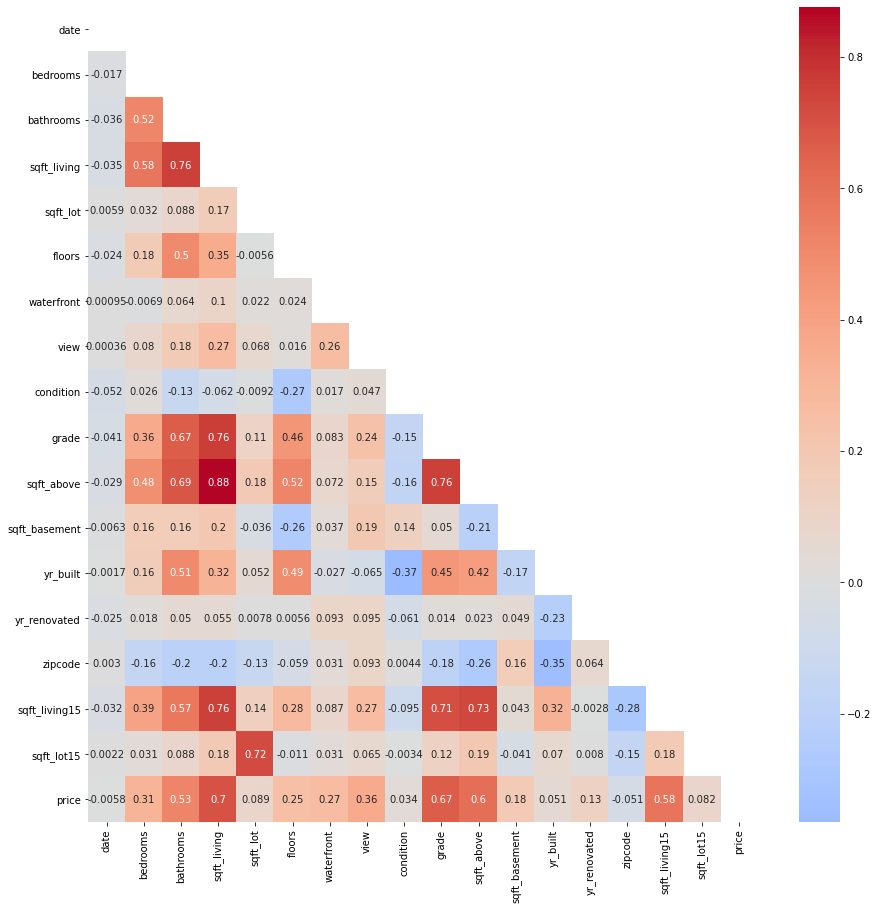

In [15]:
# check multicolinearity
fig, ax = plt.subplots(figsize=(15, 15))

mask=np.zeros_like(df_drop.corr()) # define fields we don't want to see
mask[np.triu_indices_from(mask)]=True

sns.heatmap(df_drop.corr(),  # the data for the heatmap, our dataframe
            mask=mask,  # "deactivates" all fields in our heatmap according to the mask
            annot=True,  # show the actual values of correlation in the map
            cmap='coolwarm',  # provide the 'coolwarm' colormap for the heatmap
            center=0,  # specify the value at which to center the colormap, we set it to zero, so negative correlations are displayed as negatives
           )
plt.show()

- From the heatmap we can see that sqft_living has overall higher correlation with other variables than sqft_living15. 
- Since sqft_living15 provides newer values and means the same, I will remove sqft_living. 
- The same applies in the case of sqft_lot, but here I am going to drop the newer values, since they provide overall higher correlation.
- It is okay that bathrooms and floors are highly correlated, since it's expected to have at least 0.5 bathrooms per floor, this is natural to the data.
- The Zipcode appears to provide no correlations, so I will drop it at this point
- The same applies to condition, grade seems to have greater impact on price

In [16]:
#creating a copy before further wrangling
df_copy = df_drop

In [17]:
# dropping columns as outlined above
df_drop=df_drop.drop(['sqft_living', 'sqft_lot15', 'zipcode', 'condition'], axis = 1) 

In [18]:
# control dataframe
df_drop.head()

,date,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,price
2495,735710,6,3.00,9373,2.0,0,0,7,2400,0,1991,0,2060,300000
6729,735361,4,1.75,26036,1.0,0,0,8,1160,1,1947,0,2590,647500
8404,735456,3,1.00,43000,1.0,0,0,7,1460,0,1952,0,2250,400000
8800,735689,3,1.00,7599,1.5,0,0,6,1010,1,1930,0,1290,235000
3553,735676,4,2.00,3504,1.0,0,0,7,760,1,1951,1,1480,402500


In [19]:
#switiching variables again because i'm lazy
df=df_drop

,date,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,price
2495,735710,6,3.00,9373,2.0,0,0,7,2400,0,1991,0,2060,300000
6729,735361,4,1.75,26036,1.0,0,0,8,1160,1,1947,0,2590,647500
8404,735456,3,1.00,43000,1.0,0,0,7,1460,0,1952,0,2250,400000
8800,735689,3,1.00,7599,1.5,0,0,6,1010,1,1930,0,1290,235000
3553,735676,4,2.00,3504,1.0,0,0,7,760,1,1951,1,1480,402500


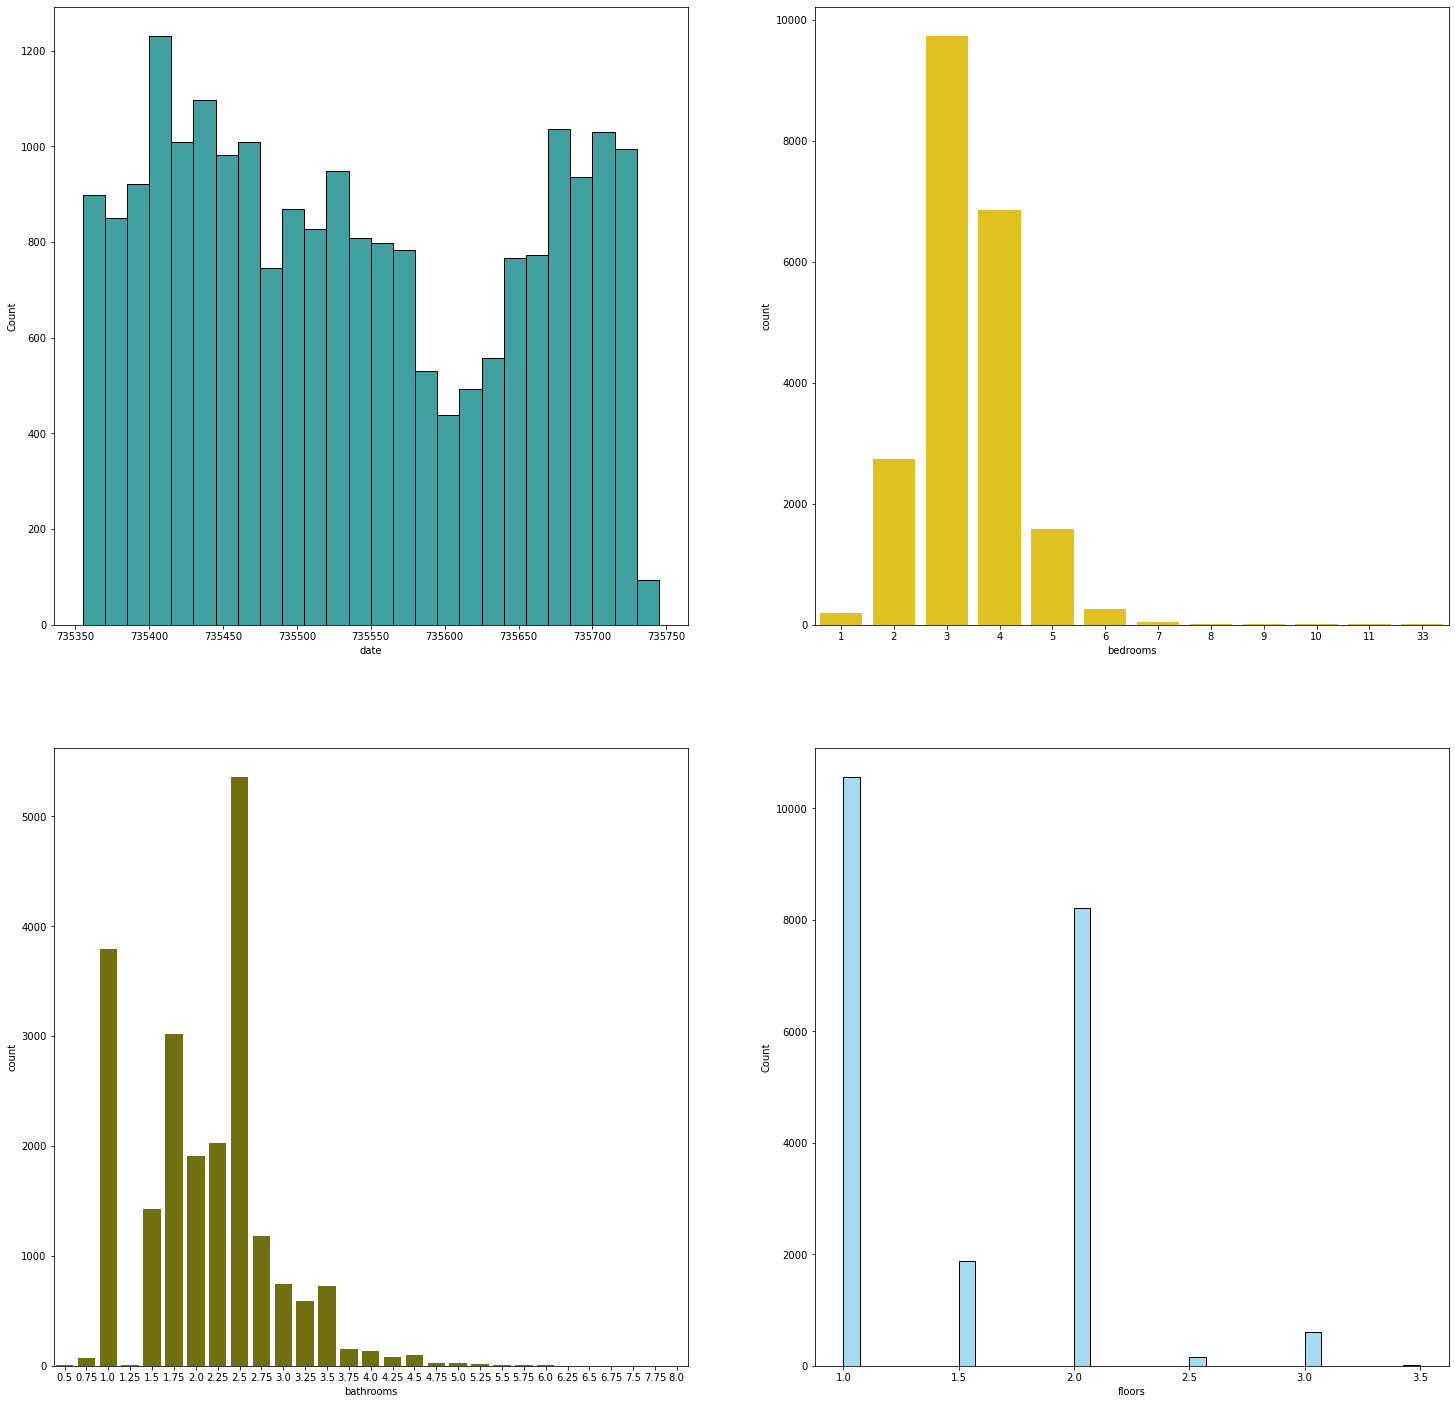

In [20]:
# take a look at distribution of variables

f, axes = plt.subplots(2, 2, figsize=(25, 25), sharex=False);
sns.histplot(x=df["date"] , color="teal", ax=axes[0, 0]);
sns.countplot(x=df["bedrooms"] , color="gold", ax=axes[0, 1]);
sns.countplot(x=df["bathrooms"], color="olive", ax=axes[1, 0]);
sns.histplot(x=df["floors"] , color="skyblue", ax=axes[1, 1]);

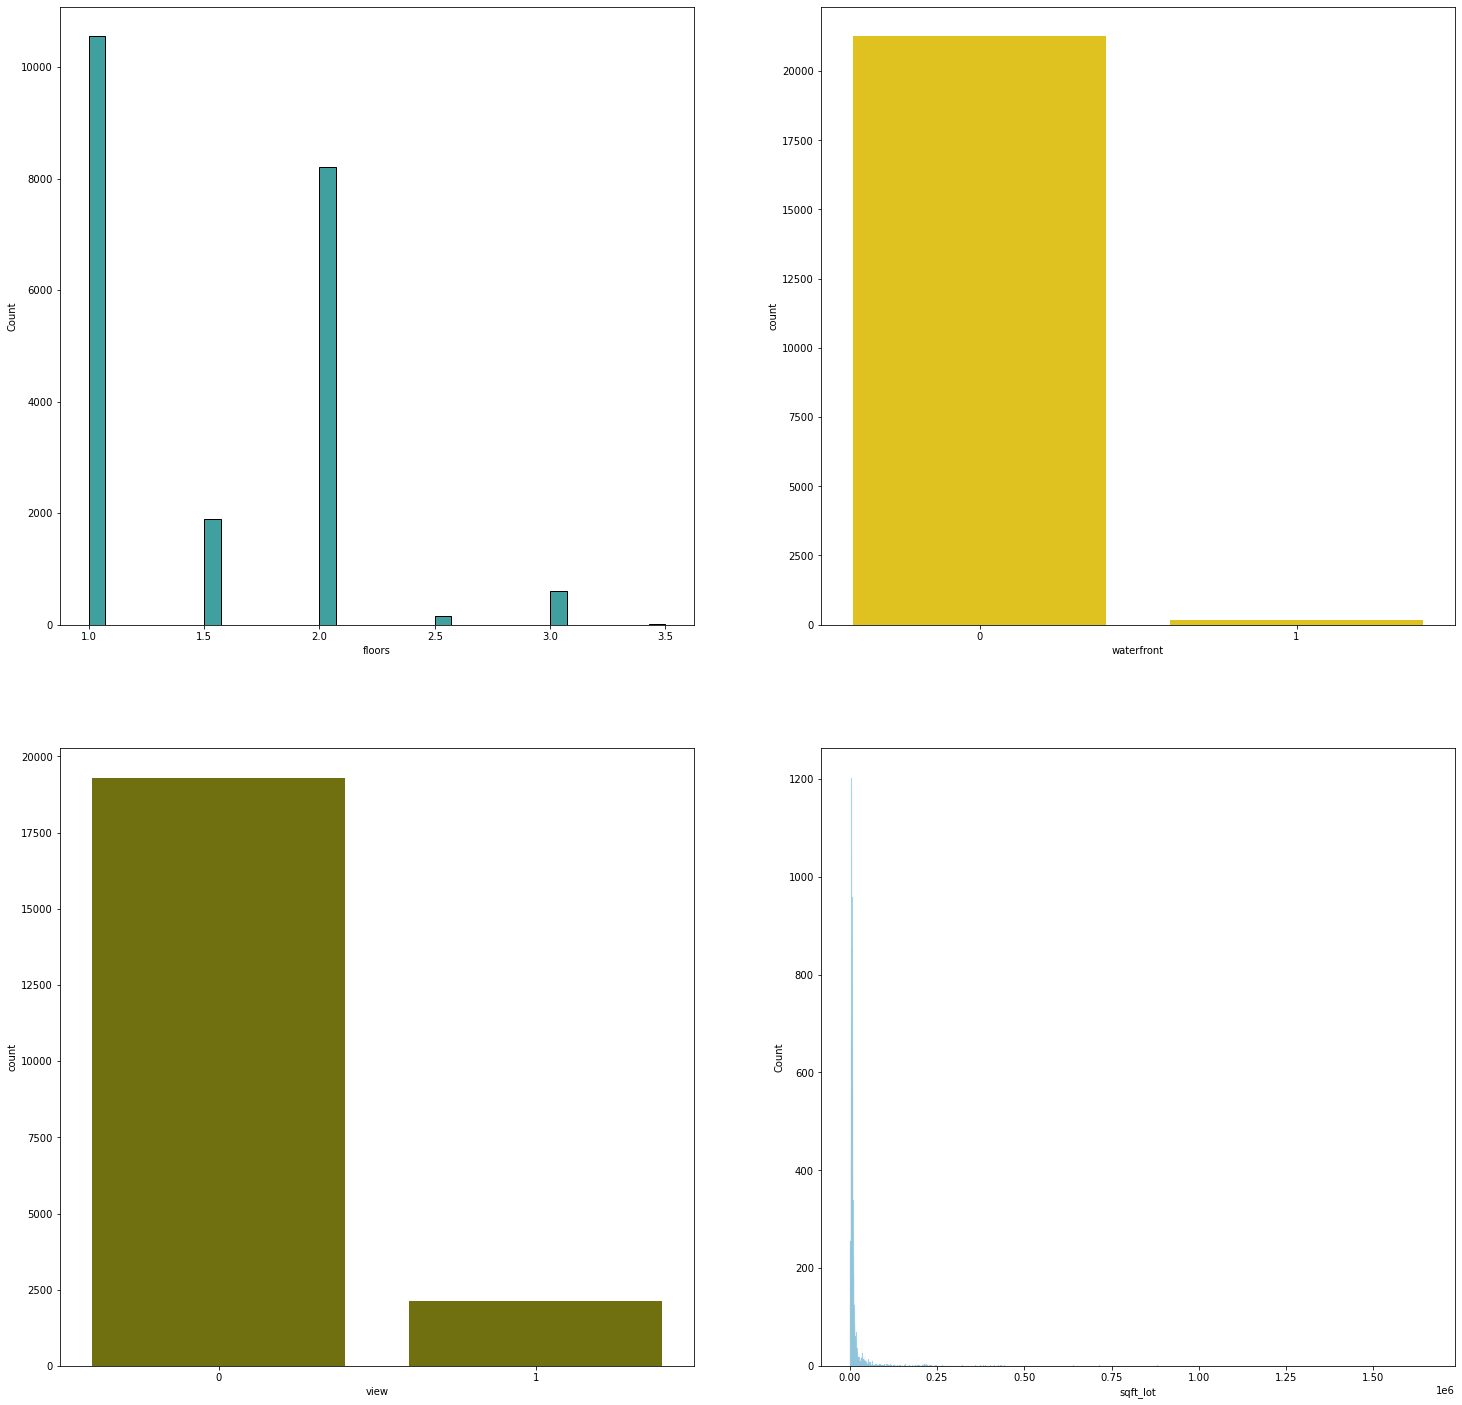

In [21]:
f, axes = plt.subplots(2, 2, figsize=(25, 25), sharex=False);
sns.histplot(x=df["floors"] , color="teal", ax=axes[0, 0]);
sns.countplot(x=df["waterfront"] , color="gold", ax=axes[0, 1]);
sns.countplot(x=df["view"], color="olive", ax=axes[1, 0]);
sns.histplot(x=df["sqft_lot"] , color="skyblue", ax=axes[1, 1]);

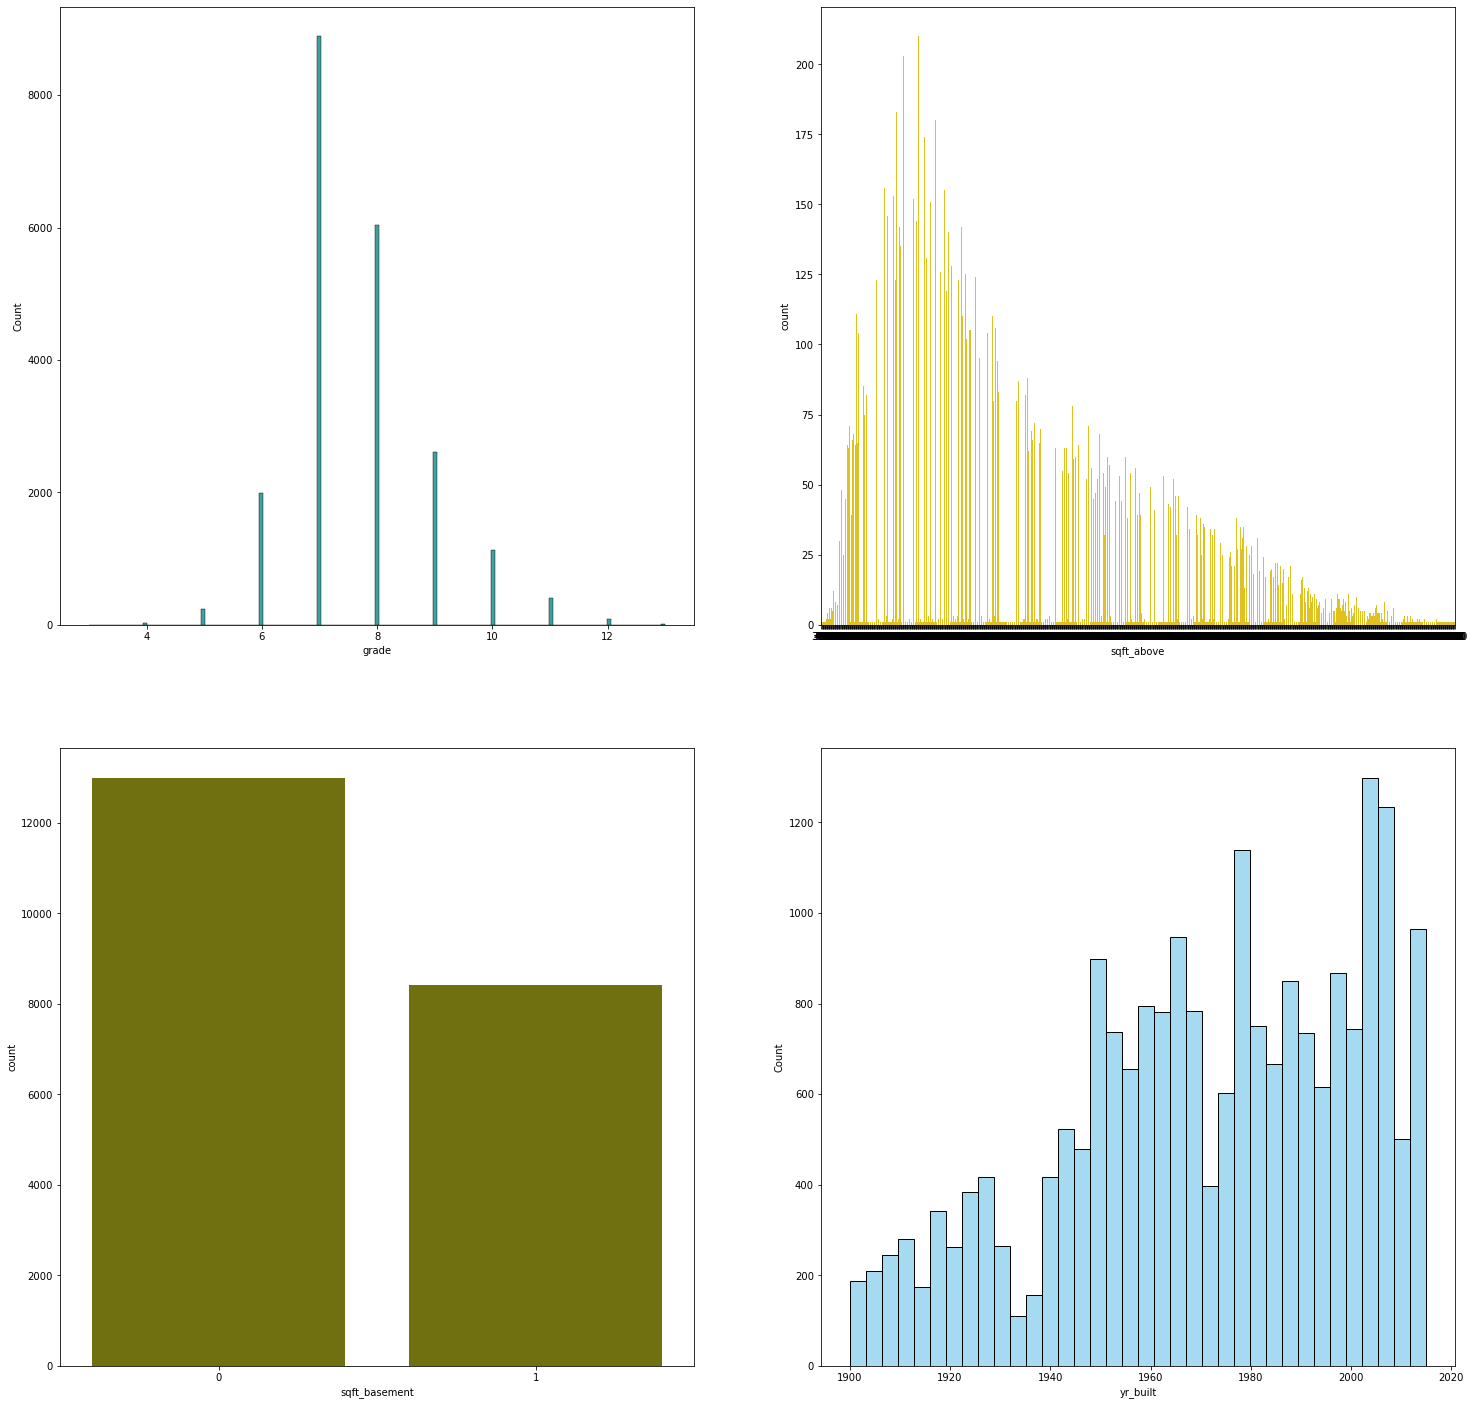

In [22]:
f, axes = plt.subplots(2, 2, figsize=(25, 25), sharex=False);
sns.histplot(x=df["grade"] , color="teal", ax=axes[0, 0]);
sns.countplot(x=df["sqft_above"] , color="gold", ax=axes[0, 1]);
sns.countplot(x=df["sqft_basement"], color="olive", ax=axes[1, 0]);
sns.histplot(x=df["yr_built"] , color="skyblue", ax=axes[1, 1]);

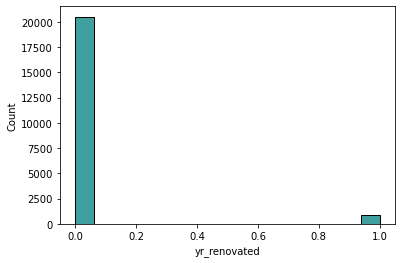

In [23]:
sns.histplot(x=df["yr_renovated"] , color="teal");

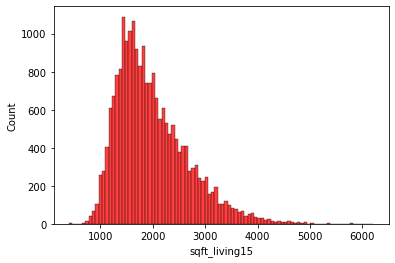

In [24]:
sns.histplot(x=df["sqft_living15"], color="red");

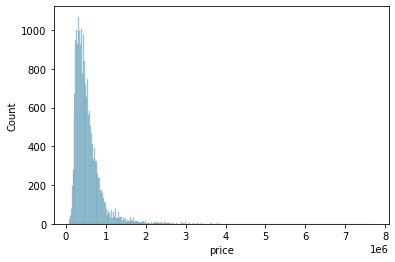

In [25]:
sns.histplot(x=df["price"] , color="skyblue");

### Observations
- yr_renovated provides no value because of the many zero values. 
- The same applies for view
- I'll assume that waterfront is driver of high prices, one of the business questions. I'll therefore keep it, but I'll also try a model without it
- The bedroom outlier observed in the eda needs to be removed manually
- sqft_living15, yr_built and sqft_above and sqft_lot are not in a uniform distribution and need transformation

In [26]:
# identify outliers in bedrooms column and print it
df = df[df['bedrooms']<=11]

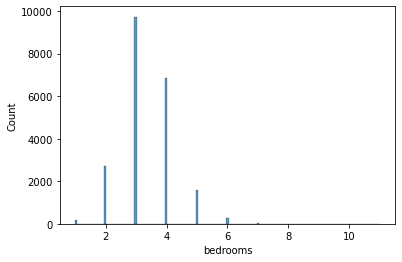

In [27]:
# see if removal worked
sns.histplot(x=df["bedrooms"]);

In [28]:
# drop columns
df=df.drop(['yr_renovated', 'view'], axis = 1) 

In [29]:
df.head(2)

,date,bedrooms,bathrooms,sqft_lot,floors,waterfront,grade,sqft_above,sqft_basement,yr_built,sqft_living15,price
2495,735710,6,3.00,9373,2.0,0,7,2400,0,1991,2060,300000
6729,735361,4,1.75,26036,1.0,0,8,1160,1,1947,2590,647500


In [30]:
# Adding a log-transform column for sqft_living15, yr_built, sqft_above and sqft_lot 
# with the goal of achieving a more uniform distribution for those columns
df["sqft_living15_log"] = np.log(df["sqft_living15"])
df["yr_built_log"] = np.log(df["yr_built"])
df["sqft_above_log"] = np.log(df["sqft_above"])
df["sqft_lot_log"] = np.log(df["sqft_lot"])

In [31]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 21419 entries, 2495 to 15937
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               21419 non-null  int64  
 1   bedrooms           21419 non-null  int64  
 2   bathrooms          21419 non-null  float64
 3   sqft_lot           21419 non-null  int64  
 4   floors             21419 non-null  float64
 5   waterfront         21419 non-null  int64  
 6   grade              21419 non-null  int64  
 7   sqft_above         21419 non-null  int64  
 8   sqft_basement      21419 non-null  int64  
 9   yr_built           21419 non-null  int64  
 10  sqft_living15      21419 non-null  int64  
 11  price              21419 non-null  int64  
 12  sqft_living15_log  21419 non-null  float64
 13  yr_built_log       21419 non-null  float64
 14  sqft_above_log     21419 non-null  float64
 15  sqft_lot_log       21419 non-null  float64
dtypes: float64(6), int6

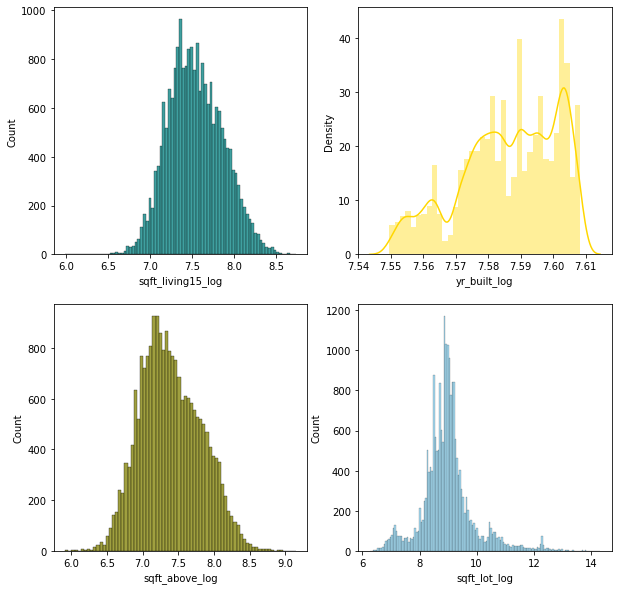

In [32]:
# check distribution of the log columns
f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=False);
sns.histplot( df["sqft_living15_log"] , color="teal", ax=axes[0, 0]);
sns.distplot( df["yr_built_log"] , color="gold", ax=axes[0, 1]);
sns.histplot( df["sqft_above_log"] , color="olive", ax=axes[1, 0]);
sns.histplot( df["sqft_lot_log"] , color="skyblue", ax=axes[1, 1]);

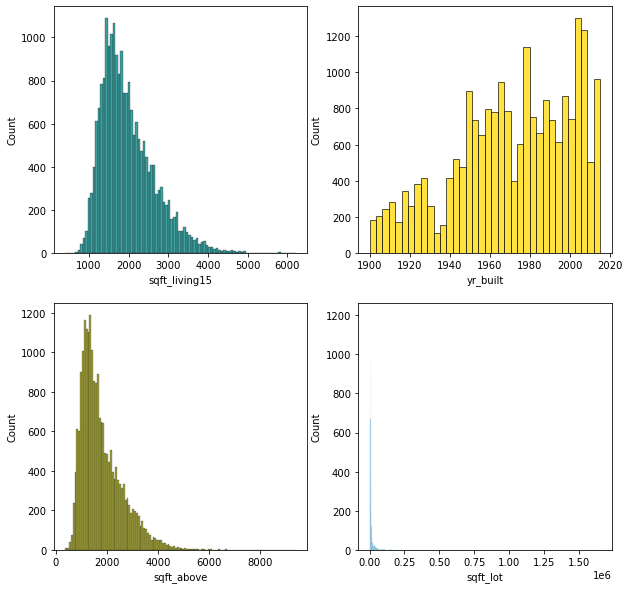

In [33]:
# compare with normal distribution
f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=False);
sns.histplot( df["sqft_living15"] , color="teal", ax=axes[0, 0]);
sns.histplot( df["yr_built"] , color="gold", ax=axes[0, 1]);
sns.histplot( df["sqft_above"] , color="olive", ax=axes[1, 0]);
sns.histplot( df["sqft_lot"] , color="skyblue", ax=axes[1, 1]);

These four variables look a lot better after the log transform. I will drop the original columns, and create a new dataframe for that 

In [34]:
df_wrangled=df.drop(["sqft_living15","yr_built", "sqft_above", "sqft_lot"], axis=1)
df_wrangled.head()

,date,bedrooms,bathrooms,floors,waterfront,grade,sqft_basement,price,sqft_living15_log,yr_built_log,sqft_above_log,sqft_lot_log
2495,735710,6,3.00,2.0,0,7,0,300000,7.630461,7.596392,7.783224,9.145588
6729,735361,4,1.75,1.0,0,8,1,647500,7.859413,7.574045,7.056175,10.167235
8404,735456,3,1.00,1.0,0,7,0,400000,7.718685,7.576610,7.286192,10.668955
8800,735689,3,1.00,1.5,0,6,1,235000,7.162397,7.565275,6.917706,8.935772
3553,735676,4,2.00,1.0,0,7,1,402500,7.299797,7.576097,6.633318,8.161660


For the last data wrangling step before applying models I will create a second dataframe that includes normalised variables
We use preprocessing from the sklearn model to achieve this


In [35]:
x = df_wrangled.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler() # choose the model with which we are normalizin
x_scaled = min_max_scaler.fit_transform(x) # create normalized values
df_norm = pd.DataFrame(x_scaled) # create new normalized dataframe
df_norm.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.910256,0.5,0.333333,0.4,0.0,0.4,0.0,0.029126,0.598006,0.796101,0.577783,0.358633
1,0.015385,0.3,0.166667,0.0,0.0,0.5,1.0,0.074718,0.681414,0.415821,0.353110,0.485337
2,0.258974,0.2,0.066667,0.0,0.0,0.4,0.0,0.042246,0.630147,0.459465,0.424190,0.547560
3,0.856410,0.2,0.066667,0.2,0.0,0.3,1.0,0.020598,0.427488,0.266588,0.310320,0.332612
4,0.823077,0.3,0.200000,0.0,0.0,0.4,1.0,0.042574,0.477544,0.450745,0.222438,0.236607


In [36]:
#define headers for the normalized dataframe
df_norm.columns =["date", "bedrooms","bathrooms", "floors", "waterfront", "grade", "basement", "price", "sqft_living15_log", "yr_built_log", "sqft_above_log", "sqft_lot_log"]
df_norm.head(1)

,date,bedrooms,bathrooms,floors,waterfront,grade,basement,price,sqft_living15_log,yr_built_log,sqft_above_log,sqft_lot_log
0,0.910256,0.5,0.333333,0.4,0.0,0.4,0.0,0.029126,0.598006,0.796101,0.577783,0.358633


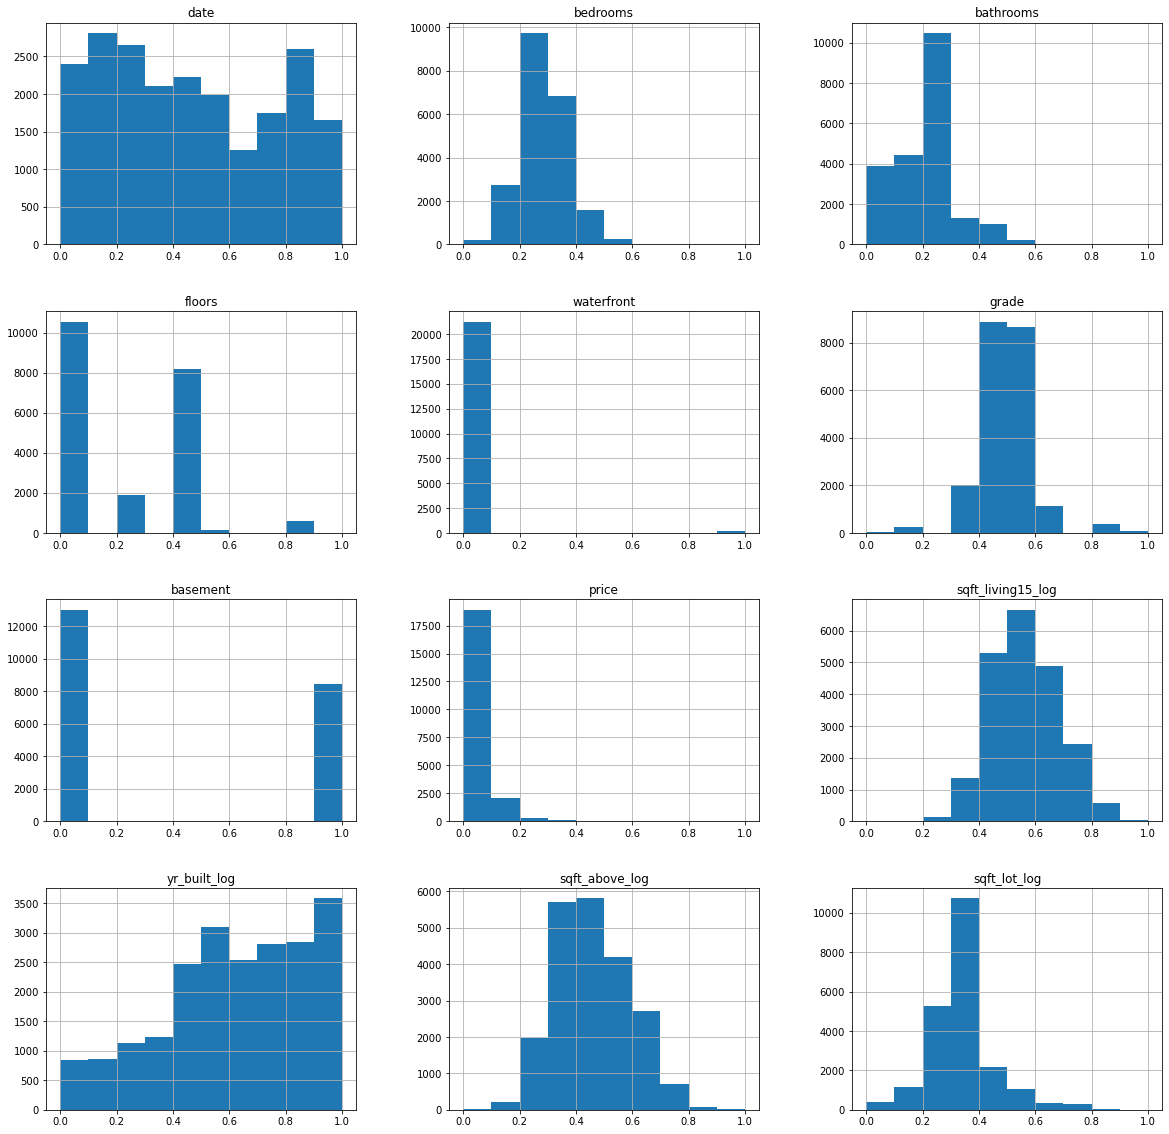

In [37]:
# check if the normalization worked by looking at all distributions again and seeing if they are normalized
df_norm.hist(figsize =(20,20));
plt.show;

## Applying a linear regression model to the non-normalized dataframe

In [38]:
'''Defining the variables:
Y as 'price' - the variable we want to predict,
and X as all other columns of our dataframe.'''

y = df_wrangled['price'] # define Y as price, the variable that will be predicted

X = df_wrangled.drop(['price'], axis=1) # define X as all other variables except price

### Split the data into training and testing sets
***
#### The next step will split our data into a train and a test sample so we can train the model and get a benchmark for its precision

In [39]:
'''We use sklearn train_test_split function to achieve this
the test_size is the percentage of the data we use to test our model with, 
meaning we feed it 70% of the available data. The random state generates a 
random number for the split to ensure consistency'''

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=40) 
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(14993, 11)
(6426, 11)
(14993,)
(6426,)


In [40]:
# Fitting the training data into the linear regression model
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

In [41]:
#This is the result equation's intercept (the constant)
lin_model.intercept_

-20595537.394444186

In [42]:
#These are estimated coefficients 
lin_model.coef_

array([ 1.15495667e+02, -2.42404362e+04,  1.02381564e+05, -1.72103164e+04,
        7.87638939e+05,  1.62317908e+05,  6.69677720e+04,  1.02077905e+05,
       -8.82121071e+06,  1.52839681e+05, -1.99454512e+04])

In [43]:
# A predicition array is presented
predictions  = lin_model.predict(X_test)
predictions

array([397231.28166127, 973203.75129159, 495666.57881012, ...,
       320546.482468  , 321445.91379179, 701838.80669371])

In [44]:
#This is the r2 score
r2 = r2_score(y_test, predictions)
r2

0.6290357313894337

In [45]:
#This is the RMSE
mse = mean_squared_error(y_test, predictions)
rmse = math.sqrt(mse)
print(rmse)

212384.17573944372


### Below, you can see the regression model's predictions compared against the y_test values

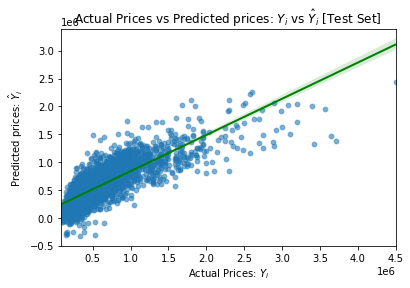

In [46]:
sns.scatterplot(y_test, predictions, alpha=0.4)
sns.regplot(y_test, predictions, truncate=True, scatter_kws={'s': 20, 'alpha':0.3}, line_kws={'color':'green', 'linewidth': 2})

plt.xlabel("Actual Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Actual Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$ [Test Set]")
 
plt.show()

# Comparing this to the normalized dataframe

In [47]:
'''Defining the variables:
Y as 'price' - the variable we want to predict,
and X as all other columns of our dataframe.'''

y = df_norm['price'] # define Y as price, the variable that will be predicted

X = df_norm.drop(['price'], axis=1) # define X as all other variables except price

In [48]:
'''We use sklearn train_test_split function to achieve this
the test_size is the percentage of the data we use to test our model with, 
meaning we feed it 70% of the available data. The random state generates a 
random number for the split to ensure consistency'''

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=40) 
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(14993, 11)
(6426, 11)
(14993,)
(6426,)


In [49]:
# Fitting the training data into the linear regression model
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

In [50]:
#This is the result equation's intercept (the constant)
lin_model.intercept_

-0.05940664786924327

In [51]:
#These are estimated coefficients 
lin_model.coef_

array([ 0.00590964, -0.03180325,  0.10074281, -0.00564495,  0.10333757,
        0.21295973,  0.00878612,  0.0367619 , -0.06801117,  0.06489019,
       -0.02110021])

In [52]:
# A predicition array is presented
predictions  = lin_model.predict(X_test)
predictions

array([0.04188288, 0.11744998, 0.0547975 , ..., 0.03182189, 0.0319399 ,
       0.08184713])

In [53]:
#This is the r2 score
r2 = r2_score(y_test, predictions)
r2

0.6290357313894257

In [54]:
#This is the RMSE
mse = mean_squared_error(y_test, predictions)
rmse = math.sqrt(mse)
print(rmse)

0.02786462552341197


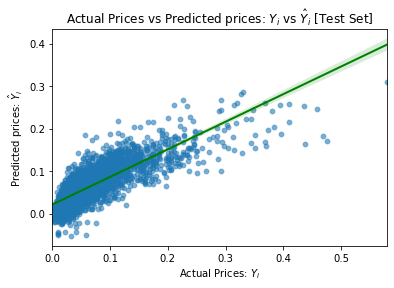

In [55]:
sns.scatterplot(y_test, predictions, alpha=0.4)
sns.regplot(y_test, predictions, truncate=True, scatter_kws={'s': 20, 'alpha':0.3}, line_kws={'color':'green', 'linewidth': 2})

plt.xlabel("Actual Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Actual Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$ [Test Set]")
 
plt.show()

## Normalizing does not have a impact on our predictions
The r2 is exactly the same

#### Unnormalized dataframe:   

R2: 0.6290357313894257

RSME: 212384.17573944372


#### Normalized dataframe: 

R2: 0.6290357313894257 

RSME: 0.02786462552341197 (which was to expect since we normalized price as well)


#### Original model:

R2: 0.6076623894802664

RSME: 217122.00721913826
***
For linear regression, the refinement only brought slight improvements compared to the original model. I will check polynomial regression below

***
### Polynomial regression model
***
In this section, the model from the previous section is converted into a Polynomial model of order 2. After this, a regression model is run and predictions are obtained.

In [56]:
'''Defining the variables:
Y as 'price' - the variable we want to predict,
and X as all other columns of our dataframe.'''

y = df_wrangled['price'] # define Y as price, the variable that will be predicted

X = df_wrangled.drop(['price'], axis=1) # define X as all other variables except price

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=40) 
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(14993, 11)
(6426, 11)
(14993,)
(6426,)


In [58]:
def create_polynomial_regression_model(degree):
  
  poly_features = PolynomialFeatures(degree=degree)
  
  # With this line of code, the previous's section model is transformed into higher features
  X_train_poly = poly_features.fit_transform(X_train)
  
  # The transformed features are fitted to a polinomial regression
  poly_model = LinearRegression()
  poly_model.fit(X_train_poly, y_train)
  
  # A prediction on the training data set is conducted
  y_train_predicted = poly_model.predict(X_train_poly)
  
  # A prediciton on the test data set is carried out
  y_test_predict = poly_model.predict(poly_features.fit_transform(X_test))
  
  # The training dataset is evaluated
  rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predicted))
  r2_train = r2_score(y_train, y_train_predicted)
  
  # Model'S evaluation on the test data set
  rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
  r2_test = r2_score(y_test, y_test_predict)
  
  print("The model's performance for the training set")
  print("-------------------------------------------")
  print("Training set's RMSE is {}".format(rmse_train))
  print("Training set's R_2 score is {}".format(r2_train))
  
  print("\n")
  
  print("The model performance for the test set")
  print("-------------------------------------------")
  print("Testing set's RMSE is {}".format(rmse_test))
  print("Testing set's R_2 score is {}".format(r2_test))  
    
create_polynomial_regression_model(1)

The model's performance for the training set
-------------------------------------------
Training set's RMSE is 235637.41876020082
Training set's R_2 score is 0.6058742389487826


The model performance for the test set
-------------------------------------------
Testing set's RMSE is 212384.1757394495
Testing set's R_2 score is 0.6290357313894136


In [59]:
#These are the predicted values
degree=2
poly_features = PolynomialFeatures(degree=degree)
X_train_poly = poly_features.fit_transform(X_train)
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
y_train_predicted = poly_model.predict(X_train_poly)
y_test_predict = poly_model.predict(poly_features.fit_transform(X_test))
y_test_predict 

array([ 356350.76531982, 1042083.98309326,  495020.175354  , ...,
        303111.88031006,  323220.07763672,  687623.99554443])

### Below, you can see the polynomial model's predictions compared against the y_test values

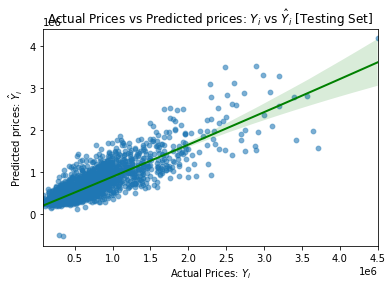

In [60]:
sns.scatterplot(y_test, y_test_predict, alpha=0.4)
sns.regplot(y_test, y_test_predict, scatter_kws={'s': 20, 'alpha':0.3}, line_kws={'color':'green', 'linewidth': 2}, order=2)
 
plt.xlabel("Actual Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Actual Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$ [Testing Set]")
 
plt.show()

# Comparison linear <> polynomial regression

#### Linear regression
- Unnormalized dataframe:

R2: 0.6290357313894257

RSME: 212384.17573944372

- Normalized dataframe:

R2: 0.6290357313894257

RSME: 0.02786462552341197 

#### Polynomial regression

R2: 0.6290357313894136 (slightly worse than linear regression

RMSE: 212384.1757394495

## I will check if further wrangling can improve the result

In [61]:
# we start with our wrangled dataset and assign a new variable for our further steps
df_wrangled.head()


,date,bedrooms,bathrooms,floors,waterfront,grade,sqft_basement,price,sqft_living15_log,yr_built_log,sqft_above_log,sqft_lot_log
2495,735710,6,3.00,2.0,0,7,0,300000,7.630461,7.596392,7.783224,9.145588
6729,735361,4,1.75,1.0,0,8,1,647500,7.859413,7.574045,7.056175,10.167235
8404,735456,3,1.00,1.0,0,7,0,400000,7.718685,7.576610,7.286192,10.668955
8800,735689,3,1.00,1.5,0,6,1,235000,7.162397,7.565275,6.917706,8.935772
3553,735676,4,2.00,1.0,0,7,1,402500,7.299797,7.576097,6.633318,8.161660


In [62]:
# First try is simple linear regression without the date column since it could skew the model 
'''Defining the variables:
Y as 'price' - the variable we want to predict,
and X as all other columns except date of our dataframe.'''

y = df_wrangled['price'] # define Y as price, the variable that will be predicted

X = df_wrangled.drop(['price', 'date'], axis=1) # define X as all other variables except date and price

In [63]:
#splitting the dara

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=40) 
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(14993, 10)
(6426, 10)
(14993,)
(6426,)


In [64]:
# Fitting the training data into the linear regression model
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

In [65]:
#This is the result equation's intercept (the constant)
lin_model.intercept_

64201101.1345152

In [66]:
#These are estimated coefficients 
lin_model.coef_

array([  -24272.05536105,   101797.59221674,   -17602.05225116,
         788608.12761662,   161804.217303  ,    67187.02610971,
         101929.32299821, -8800910.95188454,   154085.70749348,
         -20143.88680802])

In [67]:
# A predicition array is presented
predictions  = lin_model.predict(X_test)
predictions

array([380848.4007494 , 951901.22535047, 479633.71503145, ...,
       325809.97708335, 342204.10881339, 705567.06215645])

In [68]:
#This is the r2 score
r2 = r2_score(y_test, predictions)
r2

0.6293756496701295

In [69]:
mse = mean_squared_error(y_test, predictions)
rmse = math.sqrt(mse)
print(rmse)

212286.84856347472


#### Linear regressiom
- Unnormalized dataframe:

R2: 0.6290357313894257

RSME: 212384.17573944372
    
- Unnormalized date removed

R2: 0.6293756496701295 (slightly improved)
    
RSME: 212286.84856347472 (slightly improved)
***

In [70]:
# Another try is simple linear regression without the date & waterfront column since it could skew the model 
'''Defining the variables:
Y as 'price' - the variable we want to predict,
and X as all other columns except date of our dataframe.'''

y = df_wrangled['price'] # define Y as price, the variable that will be predicted

X = df_wrangled.drop(['price', 'date', 'waterfront'], axis=1) # define X as all other variables except date and price

In [71]:
#splitting the dara
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=40) 

# Fitting the training data into the linear regression model
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

In [72]:
#This is the r2 score
r2 = r2_score(y_test, predictions)
r2

0.6293756496701295

In [73]:
# RSME of the model
mse = mean_squared_error(y_test, predictions)
rmse = math.sqrt(mse)
print(rmse)

212286.84856347472


### This model performt worse than using waterfront, so it stays in the dataframe

I will continue without the date column, but lets check if we can add some data back and improve the model

I will try to run a modell with scaled and preprocessed data from the original dataframe minus the date column. I will use standardscaler to achieve some scaling of the data

In [80]:
# recall the unwrangled copy
df_copy

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,price
2495,735710,6,3.00,2400,9373,2.0,0,0,3,7,2400,0,1991,0,98002,2060,7316,300000
6729,735361,4,1.75,2060,26036,1.0,0,0,4,8,1160,1,1947,0,98166,2590,21891,647500
8404,735456,3,1.00,1460,43000,1.0,0,0,3,7,1460,0,1952,0,98166,2250,20023,400000
8800,735689,3,1.00,1430,7599,1.5,0,0,4,6,1010,1,1930,0,98168,1290,10320,235000
3553,735676,4,2.00,1650,3504,1.0,0,0,3,7,760,1,1951,1,98144,1480,3504,402500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16723,735439,5,2.00,1600,4168,1.5,0,0,3,7,1600,0,1927,0,98126,1190,4168,365000
3257,735668,2,1.00,1040,7372,1.0,0,0,5,7,840,1,1939,0,98126,1930,5150,380000
7614,735408,3,1.00,1100,4128,1.0,0,0,4,7,720,1,1942,0,98126,1510,4538,339000
20963,735417,2,1.75,1410,1005,1.5,0,0,3,9,900,1,2011,0,98027,1440,1188,399900


In [81]:
# remove date
df_copy=df_copy.drop(['date'], axis = 1) 

In [85]:
# applying the standardscaler
transformer = StandardScaler().fit(df_copy.iloc[:,:-1]) # scale all data except last colum, price

x_standardized = transformer.transform(df_copy.iloc[:,:-1])

In [88]:
# assign column headers
full_standardized = pd.DataFrame(x_standardized,columns=df_copy.columns.tolist()[:-1]) # assign names from former dataframe minus price
#check dataframe
full_standardized.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15
0,2.837799,1.146831,0.344876,-0.138576,0.933243,-0.087567,-0.330907,-0.631956,-0.565549,0.734704,-0.804872,0.677421,-0.210639,-1.418843,0.104469,-0.199661
1,0.676531,-0.479287,-0.025177,0.262654,-0.918375,-0.087567,-0.330907,0.906458,0.287734,-0.761663,1.242433,-0.819867,-0.210639,1.647940,0.877604,0.333344
2,-0.404103,-1.454958,-0.678212,0.671131,-0.918375,-0.087567,-0.330907,-0.631956,-0.565549,-0.399639,-0.804872,-0.649721,-0.210639,1.647940,0.381631,0.265031
3,-0.404103,-1.454958,-0.710864,-0.181292,0.007434,-0.087567,-0.330907,0.906458,-1.418832,-0.942675,1.242433,-1.398365,-0.210639,1.685340,-1.018764,-0.089805
4,0.676531,-0.154064,-0.471418,-0.279896,-0.918375,-0.087567,-0.330907,-0.631956,-0.565549,-1.244362,1.242433,-0.683750,4.747469,1.236542,-0.741602,-0.339065


In [89]:
# fit the LR model
X = full_standardized
y = df_copy['price']

In [90]:
#splitting the dara
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=40) 

# Fitting the training data into the linear regression model
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

In [91]:
r2 = r2_score(y_test, predictions)
r2

0.26421782049918396

In [93]:
# fit the polynomial regression model
def create_polynomial_regression_model(degree):
  
  poly_features = PolynomialFeatures(degree=degree)
  
  # With this line of code, the previous's section model is transformed into higher features
  X_train_poly = poly_features.fit_transform(X_train)
  
  # The transformed features are fitted to a polinomial regression
  poly_model = LinearRegression()
  poly_model.fit(X_train_poly, y_train)
  
  # A prediction on the training data set is conducted
  y_train_predicted = poly_model.predict(X_train_poly)
  
  # A prediciton on the test data set is carried out
  y_test_predict = poly_model.predict(poly_features.fit_transform(X_test))
  
  # The training dataset is evaluated
  rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predicted))
  r2_train = r2_score(y_train, y_train_predicted)
  
  # Model'S evaluation on the test data set
  rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
  r2_test = r2_score(y_test, y_test_predict)
  
  print("The model's performance for the training set")
  print("-------------------------------------------")
  print("Training set's RMSE is {}".format(rmse_train))
  print("Training set's R_2 score is {}".format(r2_train))
  
  print("\n")
  
  print("The model performance for the test set")
  print("-------------------------------------------")
  print("Testing set's RMSE is {}".format(rmse_test))
  print("Testing set's R_2 score is {}".format(r2_test))  
    
create_polynomial_regression_model(1)

The model's performance for the training set
-------------------------------------------
Training set's RMSE is 217714.01425207555
Training set's R_2 score is 0.6528813544501639


The model performance for the test set
-------------------------------------------
Testing set's RMSE is 214824.37136192547
Testing set's R_2 score is 0.6495489329602582


### The polynomial model performed even better with this new dataset

Old Highscore: 

R2: 0.6293756496701295

RSME: 212286.84856347472

New Highscores: 

R_2: 0.6495489329602582

RMSE: 214824.37136192547 (slightly worse)


### One more run without waterfront column, polynomial regression

In [102]:
X = full_standardized.drop(['waterfront'], axis = 1) 
y = df_copy['price']

In [103]:
#splitting the dara
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=40) 

# Fitting the training data into the linear regression model
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

In [104]:
def create_polynomial_regression_model(degree):
  
  poly_features = PolynomialFeatures(degree=degree)
  
  # With this line of code, the previous's section model is transformed into higher features
  X_train_poly = poly_features.fit_transform(X_train)
  
  # The transformed features are fitted to a polinomial regression
  poly_model = LinearRegression()
  poly_model.fit(X_train_poly, y_train)
  
  # A prediction on the training data set is conducted
  y_train_predicted = poly_model.predict(X_train_poly)
  
  # A prediciton on the test data set is carried out
  y_test_predict = poly_model.predict(poly_features.fit_transform(X_test))
  
  # The training dataset is evaluated
  rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predicted))
  r2_train = r2_score(y_train, y_train_predicted)
  
  # Model'S evaluation on the test data set
  rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
  r2_test = r2_score(y_test, y_test_predict)
  
  print("The model's performance for the training set")
  print("-------------------------------------------")
  print("Training set's RMSE is {}".format(rmse_train))
  print("Training set's R_2 score is {}".format(r2_train))
  
  print("\n")
  
  print("The model performance for the test set")
  print("-------------------------------------------")
  print("Testing set's RMSE is {}".format(rmse_test))
  print("Testing set's R_2 score is {}".format(r2_test))  
    
create_polynomial_regression_model(1)

The model's performance for the training set
-------------------------------------------
Training set's RMSE is 224378.0158511643
Training set's R_2 score is 0.6313062478684173


The model performance for the test set
-------------------------------------------
Testing set's RMSE is 221416.05853546216
Testing set's R_2 score is 0.6277124450937912
